Suppose we have to identify the age and gender of person basded on its image.

1. Age -Continues
2. Gender - categorical

Naive Approach:

Create 2 seprate network and then you will give the final answer.

Functional Approach:

after taking data of age and gender from image, we will perform concatination

and then you will predict the final o/p

In [ ]:
#downloading data directly from kaggle using api
#!mkdir -p ~/ .kaggle/
#!cp kaggle.json ~/.kaggle/

In [1]:
#alternate method
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 97% 320M/331M [00:02<00:00, 204MB/s]
100% 331M/331M [00:02<00:00, 140MB/s]


In [3]:
#extracting the data from zip files
import  zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf

In [5]:
folder_path = "/content/utkface_aligned_cropped/UTKFace"

In [7]:
#exctracting age and gender from Zipped files
age = []
gender = []
img_path = []

for filename in os.listdir(folder_path):
  age.append(int(filename.split("_")[0]))
  gender.append(int(filename.split("_")[1]))
  img_path.append(filename)


In [8]:
len(age)

23708

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame({'Age':age,'Gender':gender,'Image':img_path})

In [12]:
df.head()

,Age,Gender,Image
0,35,1,35_1_0_20170117121850341.jpg.chip.jpg
1,28,0,28_0_2_20170117135248701.jpg.chip.jpg
2,1,1,1_1_4_20161221201852145.jpg.chip.jpg
3,80,0,80_0_1_20170111205423680.jpg.chip.jpg
4,36,0,36_0_1_20170113151337670.jpg.chip.jpg


In [13]:
df.sample(frac=1,random_state=0)

,Age,Gender,Image
15426,1,0,1_0_2_20161219140811232.jpg.chip.jpg
14084,16,0,16_0_0_20170110232611516.jpg.chip.jpg
22319,40,0,40_0_0_20170117133805950.jpg.chip.jpg
19518,18,0,18_0_1_20170114025501676.jpg.chip.jpg
2255,15,1,15_1_4_20170104005807401.jpg.chip.jpg
...,...,...,...
13123,39,0,39_0_0_20170117154434474.jpg.chip.jpg
19648,28,0,28_0_3_20170116214434468.jpg.chip.jpg
9845,3,1,3_1_2_20161219160814805.jpg.chip.jpg
10799,3,0,3_0_0_20170110212729799.jpg.chip.jpg


In [14]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
train.head()

In [15]:
test_df = df.sample(frac=1,random_state=0).iloc[20000:]
test_df.head()

,Age,Gender,Image
9293,26,1,26_1_1_20170112213031047.jpg.chip.jpg
7515,3,1,3_1_0_20161219205449493.jpg.chip.jpg
53,65,1,65_1_0_20170120133545325.jpg.chip.jpg
6395,21,0,21_0_0_20170104230057120.jpg.chip.jpg
21250,30,1,30_1_1_20170116220801881.jpg.chip.jpg


In [16]:
print(train_df.shape)
print(test_df.shape)

(20000, 3)
(3708, 3)


In [17]:
#creating artificial data/synthetics data - Data Agumentation
from keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_data_generator = ImageDataGenerator(rescale = 1./255)


In [18]:
train_generator = train_data_generator.flow_from_dataframe(
    train_df,
    directory = folder_path,
    x_col = 'Image',
    y_col = ['Age','Gender'],
    target_size = (200,200),
    class_mode = 'multi_output'
    )


test_generator = test_data_generator.flow_from_dataframe(
    train_df,
    directory = folder_path,
    x_col = 'Image',
    y_col = ['Age','Gender'],
    target_size = (200,200),
    class_mode = 'multi_output'
    )

Found 20000 validated image filenames.
Found 20000 validated image filenames.


In [19]:
from keras.applications.resnet50 import ResNet50
from keras import *

In [20]:
#Here we are removing the fully connected neural network
resnet = ResNet50(include_top = False, input_shape = (200,200,3))


94765736/94765736 [==============================] - 0s 0us/step


In [21]:
#we are not updating the weights for convolution layer
resnet.trainable = False

In [22]:
output  = resnet.layers[-1].output
output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [23]:
#creating fully connected neural network for both the outputs
from keras.layers import Dense, Flatten
flatten = Flatten()(output)

#for 1st Output
dense1 = Dense(128,activation = 'relu')(flatten)
dense3 = Dense(128,activation = 'relu')(dense1)
dense5 = Dense(128,activation = 'relu')(dense3)
output1 = Dense(1,activation = 'linear', name = 'age')(dense5)

#for 2nd Output
dense2 = Dense(128,activation = 'relu')(flatten)
dense4 = Dense(128,activation = 'relu')(dense2)
dense6 = Dense(128,activation = 'relu')(dense4)
output2 = Dense(1,activation = 'sigmoid', name = 'gender')(dense6)

In [24]:
model = Model(inputs = resnet.input, outputs = [output1, output2])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [26]:
model.compile(optimizer='adam', loss = {'age':'mse','gender':'binary_crossentropy'},metrics = {'age':'accuracy','gender':'accuracy'})

In [27]:
model.fit(train_generator,validation_data = test_generator,epochs = 2, batch_size = 32)

Epoch 1/2
625/625 [==============================] - 315s 479ms/step - loss: 408.8667 - age_loss: 408.1035 - gender_loss: 0.7631 - age_accuracy: 0.0472 - gender_accuracy: 0.5168 - val_loss: 394.5480 - val_age_loss: 393.8550 - val_gender_loss: 0.6930 - val_age_accuracy: 0.0473 - val_gender_accuracy: 0.5209
Epoch 2/2
625/625 [==============================] - 288s 461ms/step - loss: 396.2066 - age_loss: 395.5139 - gender_loss: 0.6924 - age_accuracy: 0.0473 - gender_accuracy: 0.5209 - val_loss: 375.5601 - val_age_loss: 374.8676 - val_gender_loss: 0.6925 - val_age_accuracy: 0.0473 - val_gender_accuracy: 0.5209


In [29]:
import matplotlib.pyplot as plt
test_image = plt.imread('/content/testimage.jpg')

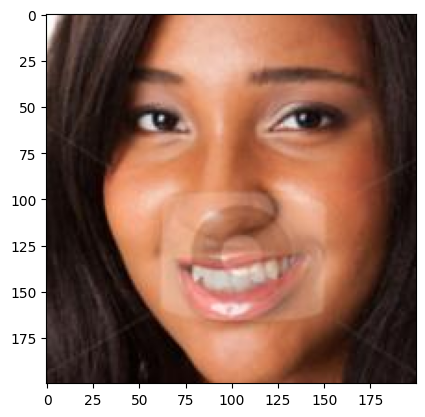

In [30]:
plt.imshow(test_image)

In [31]:
test_image.shape

(200, 200, 3)

In [34]:
import cv2 as cv
test_resize = cv.resize(test_image,(200,200))

In [35]:
test_resize.shape

(200, 200, 3)

In [36]:
test_resize=test_resize.reshape((1,200,200,3))

In [37]:
test_resize.shape

(1, 200, 200, 3)

In [38]:
pred = model.predict(test_resize)

1/1 [==============================] - 1s 1s/step


In [39]:
print(pred)

[array([[0.92706317]], dtype=float32), array([[0.5342985]], dtype=float32)]


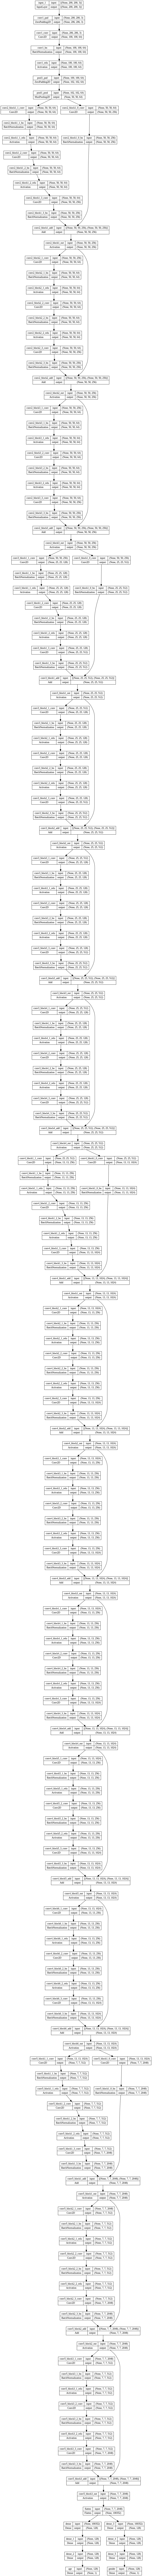

In [40]:
from keras.utils import plot_model

plot_model(model,show_shapes=True)